## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Install and Import Libraries

In [ ]:
! pip install rasterio
! pip install rioxarray
! pip install geopandas
! pip install cartopy
! pip install shapely
! pip install rasterstats
! pip install tqdm
! pip install cdsapi
! pip install colour

# restart runtime
import os
os.kill(os.getpid(), 9)

In [ ]:
# make sure
# 1) Login to Copernicus website
# 2) Accept the license terms for the account
# 3) Accept the termsof 'CMIP6 - Data Access - Terms of Use' at https://cds.climate.copernicus.eu/cdsapp/#!/terms/cmip6-wps
# 4) Use UID and API Key, not login details

url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = 'key: your-key'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

In [ ]:
%cd drive/MyDrive/

In [ ]:
import datetime
from pathlib import Path 
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import sys
import time
from rasterstats import zonal_stats
import rasterio
from tqdm import tqdm 
import zipfile
import io 
from shapely.geometry.polygon import Polygon 
from shapely.geometry.multipolygon import MultiPolygon
import cdsapi
import os
import shutil
import xarray as xr
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cftime
import cartopy.feature as cfeature
from shapely import wkt
import matplotlib.pyplot as plt
import cdsapi
from colour import Color

## Simple Data Retrieval

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-global-and-regional',
    {
        'format': 'zip',
        'origin': 'gpcc',
        'region': 'global',
        'variable': 'precipitation',
        'time_aggregation': 'monthly',
        'horizontal_aggregation': '0_25_x_0_25',
        'year': [
            '2015', '2016', '2017',
            '2018', '2019',
        ],
        'version': 'v2020.0',
    },
    'prep_station.zip')

In [ ]:
def unzipFile(path_to_zipfile, unzip_directory):
  """
  Unzip .nc file
  """
  extensions = ('.nc')
  zip_file = zipfile.ZipFile(path_to_zipfile, 'r')
  for file in zip_file.namelist():
      if file.endswith(extensions):
          zip_file.extract(file, unzip_directory)
  zip_file.close()  


In [ ]:
# California
bounds = [42.51, -124.92, 32.03, -113.63]

In [ ]:
base = '/content/drive/MyDrive/'
#file_path = os.path.join(base,'prep_station.zip')
#unzipFile(file_path, base)

In [ ]:
netcdf_fn = list(Path(base).glob('*.nc'))
netcdf_fn

[PosixPath('/content/drive/MyDrive/52impact/GPCC_total_precipitation_mon_0.25x0.25_global_2016_v2020.0.nc'),
 PosixPath('/content/drive/MyDrive/52impact/GPCC_total_precipitation_mon_0.25x0.25_global_2019_v2020.0.nc'),
 PosixPath('/content/drive/MyDrive/52impact/GPCC_total_precipitation_mon_0.25x0.25_global_2017_v2020.0.nc'),
 PosixPath('/content/drive/MyDrive/52impact/GPCC_total_precipitation_mon_0.25x0.25_global_2015_v2020.0.nc'),
 PosixPath('/content/drive/MyDrive/52impact/GPCC_total_precipitation_mon_0.25x0.25_global_2018_v2020.0.nc')]

## Data Exploration

In [ ]:
ds = xr.open_dataset(netcdf_fn[0])
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)})

# add projection system to nc
ds['pr'] = ds['pr'].rio.write_crs("epsg:4326")
ds.rio.set_spatial_dims("lon", "lat", inplace=True)

# Create new dataarray
db = xr.DataArray(ds['pr'], dims=("time", "lat", "lon"))
db.rio.set_spatial_dims("lon", "lat", inplace=True)

db

### First Visualization

Text(0.5, 1.0, 'Global Precipatation from In-situ data')

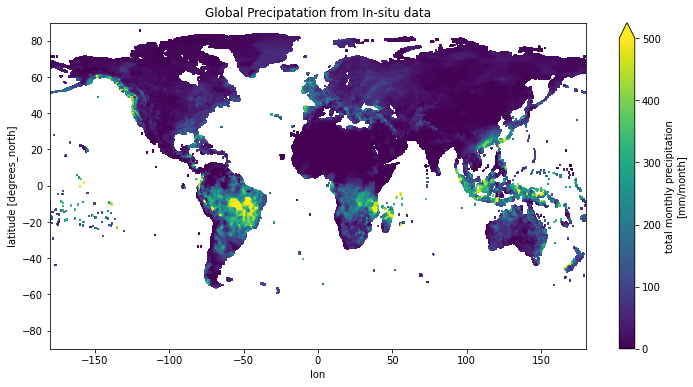

In [ ]:
db.isel(time=0).plot(aspect=2, size=6, vmin=0, vmax=500)
plt.title("Global Precipatation from In-situ data")

## Define Functions for Spatial Extraction from Rasters

In [ ]:
def get_year_nc(file):
  """
  Append dataframe for all years into single xarray df
  """
  ds = xr.open_dataset(file)
  ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)})

  # add projection system to nc
  ds['pr'] = ds['pr'].rio.write_crs("epsg:4326")
  ds.rio.set_spatial_dims("lon", "lat", inplace=True)


  # Create new dataarray (otherwise the -180 transform needed for California does not work..)
  db = xr.DataArray(ds['pr'], dims=("time", "lat", "lon"))
  db.rio.set_spatial_dims("lon", "lat", inplace=True)
  
  return db


def extract_county_pr(db, roi, county_list, df_poly):
  """
  Extract rainfall for all counties from gridded data
  """
  location = "NAME_2"

  for i in county_list:
    county = roi[roi.NAME_2 ==i]
    geo = county.geometry
    prep_county = db.rio.clip(geo, roi.crs, all_touched=True)
    prep_county_df = prep_county.to_dataframe()
    prep_county_df[location] = county[location].values[0]

    df_mean = prep_county_df.groupby(['time', location]).mean().reset_index()
    df_mean['time'] = pd.to_datetime(df_mean['time'])
    df_poly = pd.concat([df_poly, df_mean[['time', 'pr', location]]])
  
  return df_poly

In [ ]:
county_list = [shape.NAME_2 for _, shape in roi.iterrows()]

### Combine individual years

In [ ]:
df_poly = pd.DataFrame()

for f in netcdf_fn:
  db = get_year_nc(f)
  df_poly = extract_county_pr(db, roi, county_list, df_poly)

df_poly

,time,pr,NAME_2
0,2015-01-01,23.662308,Alameda
1,2015-02-01,66.477692,Alameda
2,2015-03-01,13.319231,Alameda
3,2015-04-01,31.256153,Alameda
4,2015-05-01,5.256154,Alameda
...,...,...,...
7,2019-08-01,0.224444,Yuba
8,2019-09-01,27.882223,Yuba
9,2019-10-01,10.315556,Yuba
10,2019-11-01,39.451111,Yuba


### Long to Wide transformation

In [ ]:
pr_wide = df_poly.pivot(index='time', columns='NAME_2', values='pr')

pr_wide.head()

NAME_2,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,23.662308,73.008888,64.286667,78.046669,82.392731,24.175833,26.096001,226.513992,47.839333,45.432827,...,92.317650,9.957334,3.924000,41.534286,84.296555,61.272758,94.109497,56.906841,13.027000,48.685555
2015-02-01,66.477692,136.539993,112.193329,98.069336,116.187271,72.527504,67.528000,260.263000,99.593330,55.684784,...,131.702362,46.911999,63.765003,77.746193,164.279648,69.692413,122.080002,23.968946,70.133003,95.813339
2015-03-01,13.319231,55.463333,55.430000,56.839333,63.135456,9.115833,8.790000,186.748993,43.583332,36.749783,...,33.330589,11.997334,2.509000,44.726189,74.658623,44.917587,67.974503,20.672632,2.879000,35.778889
2015-04-01,31.256153,55.247776,74.069168,67.672668,68.050003,32.005001,31.262001,98.285004,75.953331,35.434784,...,55.107059,24.757999,36.264000,46.974762,49.817585,35.296551,61.243000,15.308421,33.791000,61.265556
2015-05-01,5.256154,53.700001,27.125834,19.820667,30.721819,1.190833,2.556000,49.285999,35.720669,24.682610,...,0.789412,8.259334,3.238000,10.962381,11.766552,19.641035,41.632500,7.858421,0.975000,16.030001


In [ ]:
pr_wide.to_csv(os.path.join(base,"in_situ_pr_15_19.csv"))

In [ ]:
df_poly['year'] = df_poly.time.dt.year
df_poly.head()

,time,pr,NAME_2,year
0,2016-01-01,132.679230,Alameda,2016
1,2016-02-01,27.183846,Alameda,2016
2,2016-03-01,111.379234,Alameda,2016
3,2016-04-01,40.258461,Alameda,2016
4,2016-05-01,4.140000,Alameda,2016


## Visualization: Seasonal Profile for Different Counties in California

In [ ]:
red = Color("yellow")
colors = list(red.range_to(Color("red"),5))

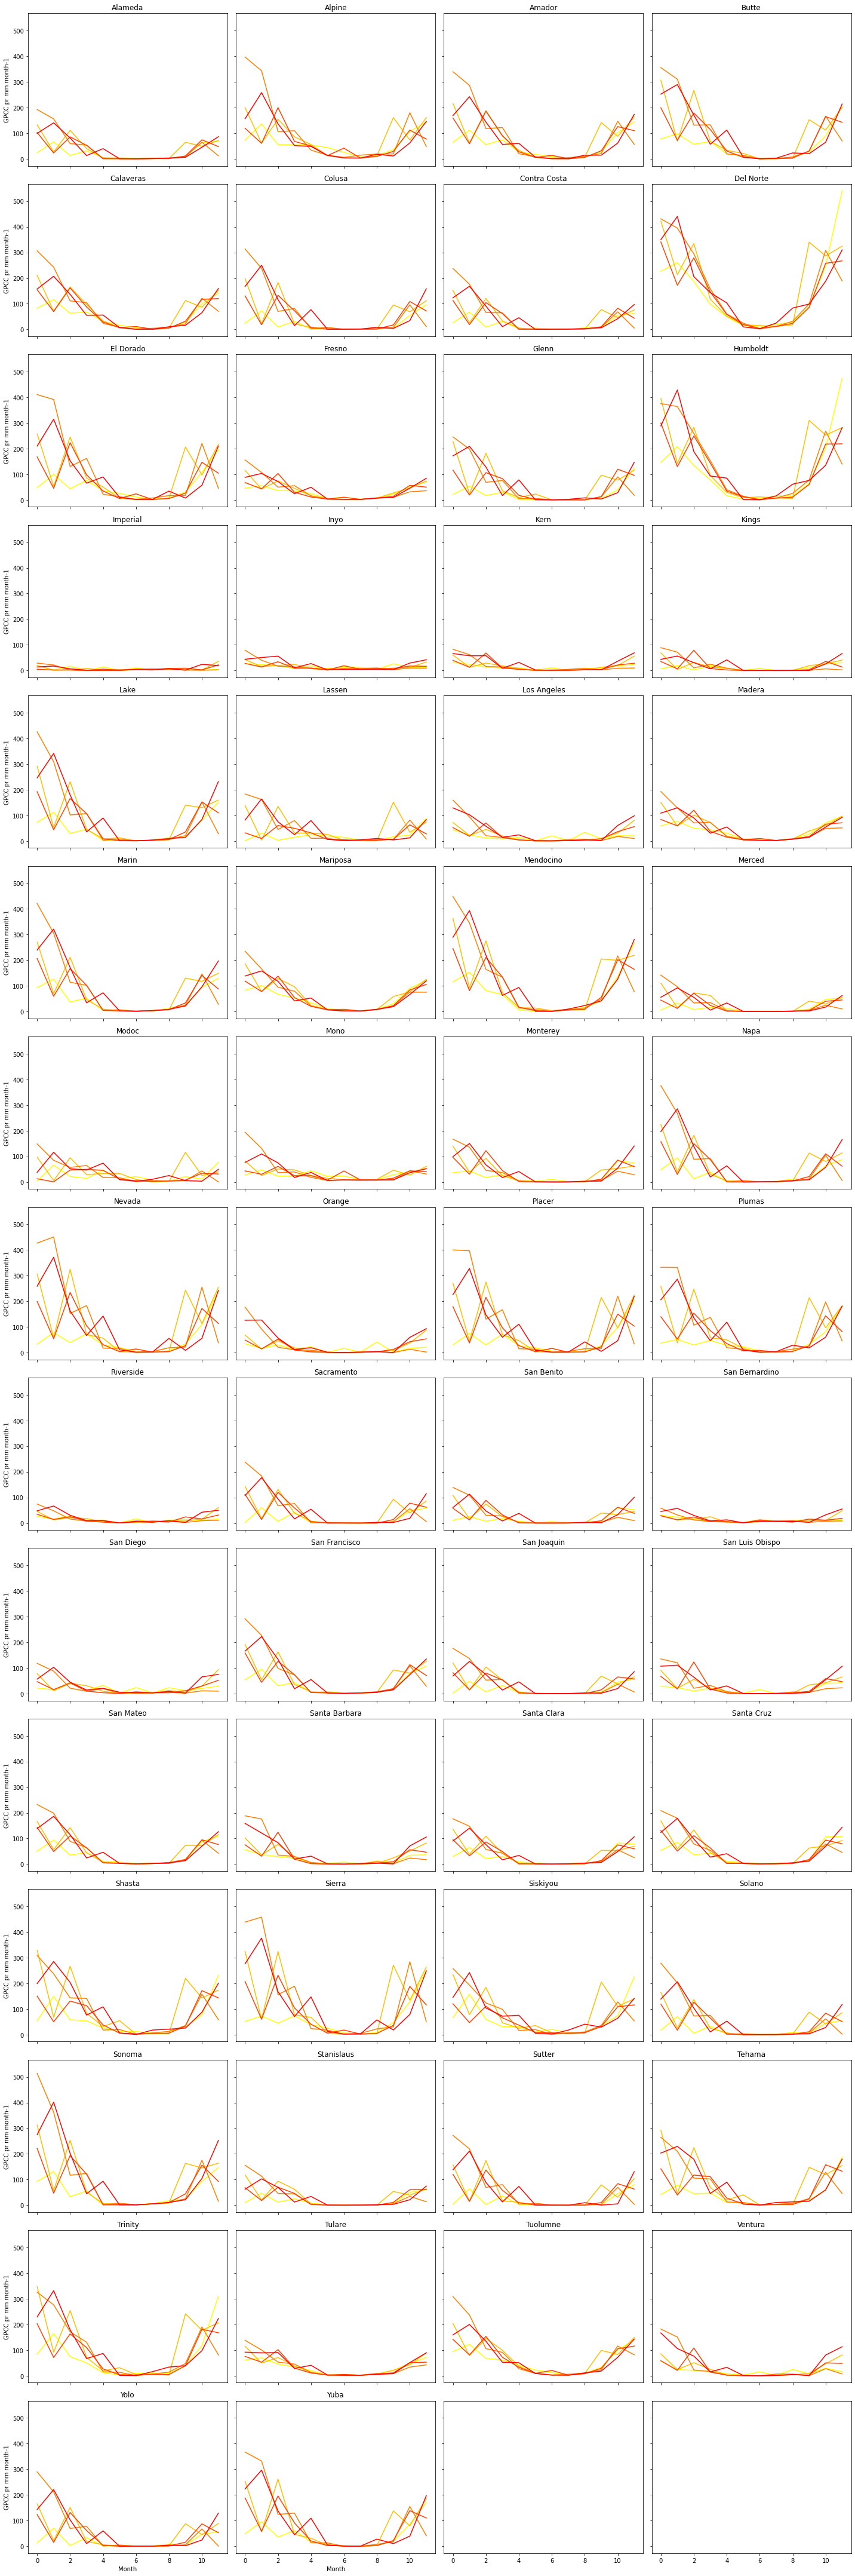

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(15,4, figsize=(20,60), sharex=True, sharey=True)
years = np.linspace(2015,2019,5)

for i, ax in enumerate(axes.flatten()):
  if i < len(county_list):
    county = county_list[i]
    for i, year in enumerate(years):
      df_poly[(df_poly.NAME_2 == county) & (df_poly.year == year)].pr.plot(color=colors[i].hex, ax=ax, label=years)
      ax.legend(loc="upper right")
      ax.set_title(county)
      ax.set_xlabel("Month")
      ax.set_ylabel("GPCC pr mm month-1")
  else:
    break

plt.tight_layout()
plt.show()

###  Cumulative Distribution Function

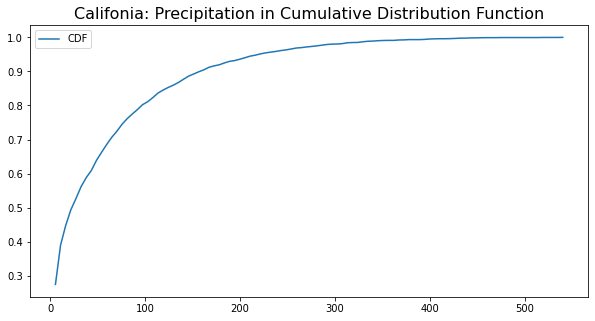

In [ ]:
# getting data of the histogram
data = df_poly#[(df_poly.NAME_2 == county_list[0])
count, bins_count = np.histogram(data.pr.values, bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.figure(figsize=(10,5))
# plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.title("Califonia: Precipitation in Cumulative Distribution Function", fontsize=16)
plt.show()

## Cumulative Distribution Function in indiviudual counties

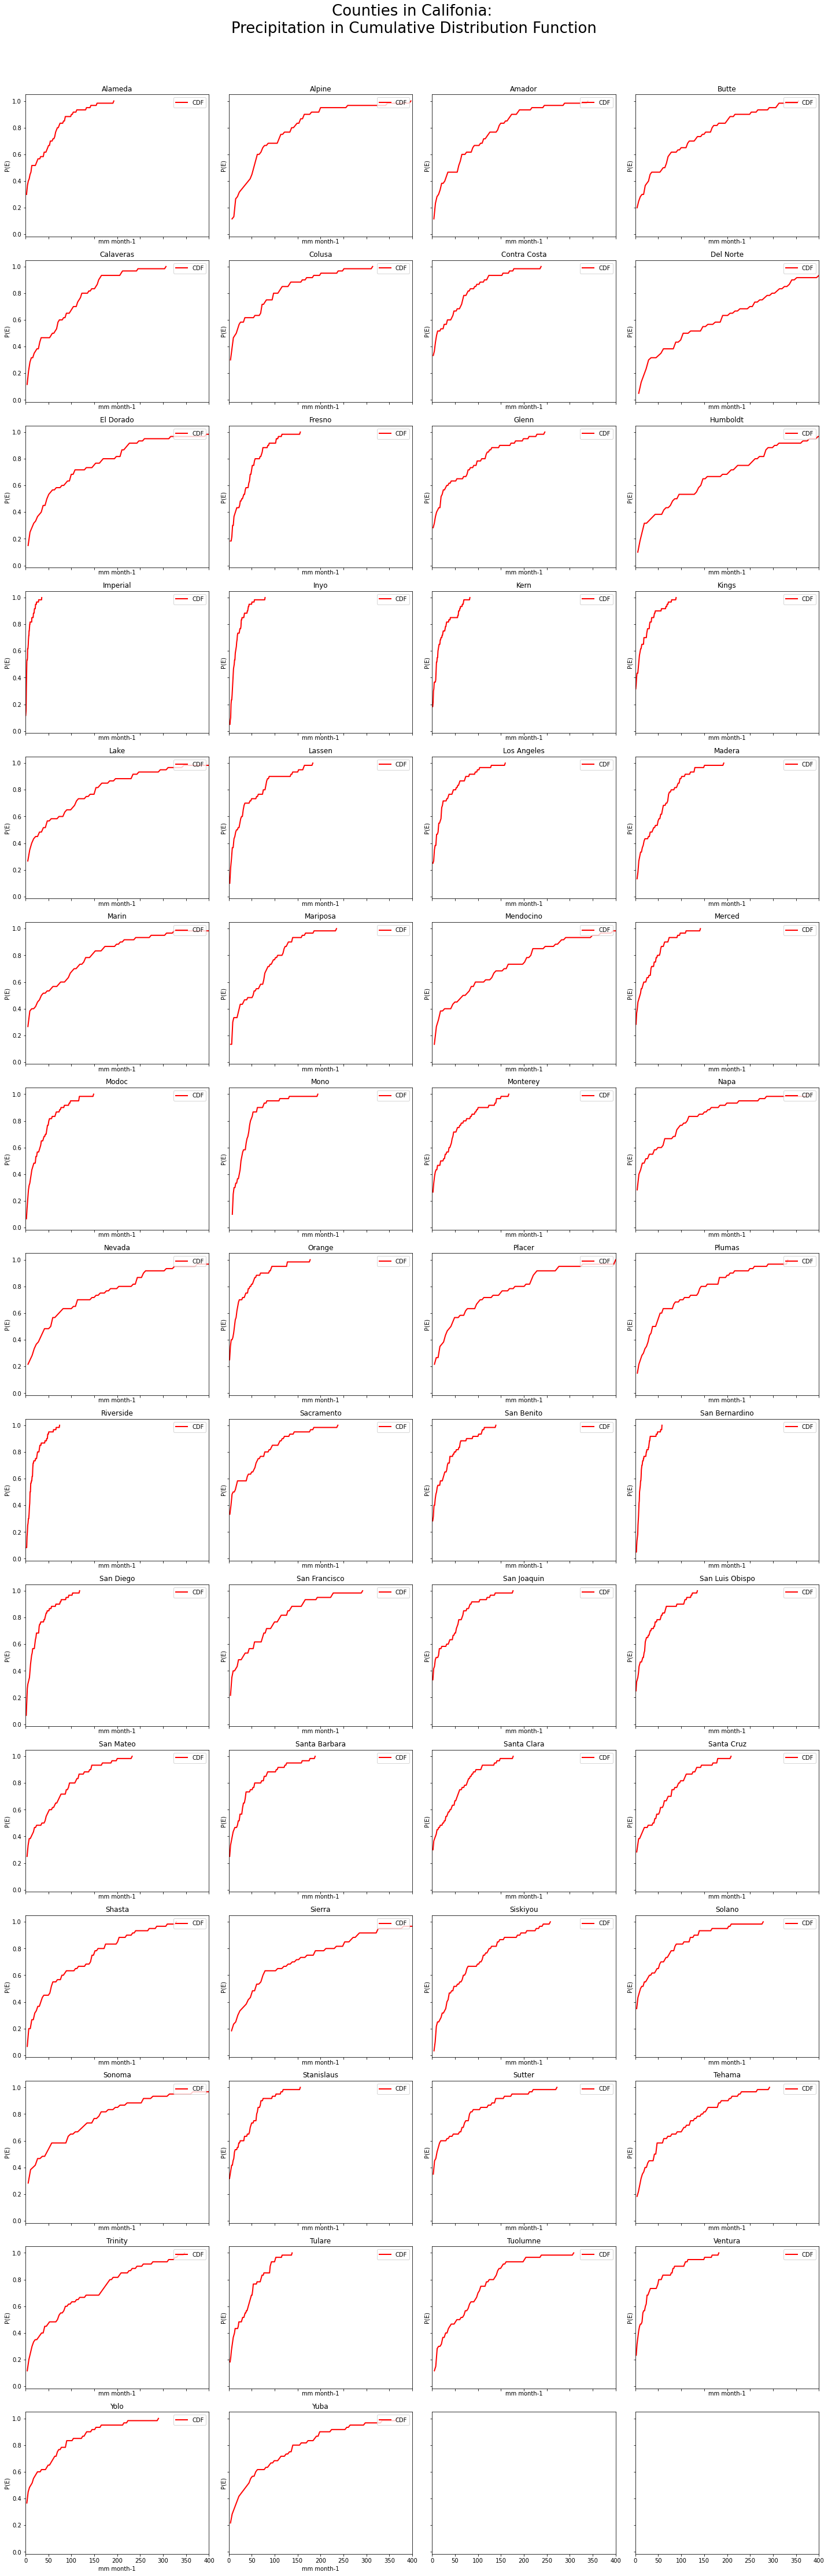

In [ ]:
fig, axes = plt.subplots(15,4, figsize=(20,60), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  if i < len(county_list):
    county = county_list[i]
    # getting data of the histogram
    data = df_poly[df_poly.NAME_2 == county]
    count, bins_count = np.histogram(data.pr.values, bins=100)
      
    # finding the PDF of the histogram using count values
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ax.plot(bins_count[1:], cdf, label="CDF", color="r", linewidth=2)
    ax.legend(loc="upper right")
    ax.set_title(county)
    ax.set_xlabel("mm month-1")
    ax.set_ylabel("P(E)")
    ax.set_xlim(0, 400)
  else:
    break

plt.suptitle("Counties in Califonia: \nPrecipitation in Cumulative Distribution Function", fontsize=26, y=1.03)
plt.tight_layout()
plt.show()